In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import optuna
import shap
from Utils import *
from matplotlib.offsetbox import AnchoredText

In [2]:
df = pd.read_csv('../data/poly_dataset.csv')
train_data = df.copy()

In [3]:
pre_data = polymer_data(train_data)
pre_data.log_cal()
fp = pre_data.get_FP()
data = pre_data.imputator(max_iter=100)

In [4]:
y_He = data['log10_He_Bayes'].to_numpy().reshape(-1, 1)
y_H2 = data['log10_H2_Bayes'].to_numpy().reshape(-1, 1)
y_N2 = data['log10_N2_Bayes'].to_numpy().reshape(-1, 1)
y_O2 = data['log10_O2_Bayes'].to_numpy().reshape(-1, 1)
y_CO2 = data['log10_CO2_Bayes'].to_numpy().reshape(-1, 1)
y_CH4 = data['log10_CH4_Bayes'].to_numpy().reshape(-1, 1)
feature_name = [str(ft) for ft in range(fp.shape[1])]


kernel = kernels.RBF() + kernels.WhiteKernel()
gas = np.array(data.iloc[:,16:])

In [5]:

X_train, X_test, y_train, y_test = train_test_split(fp, gas, test_size=0.2, random_state=190)
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, normalize_y=True, n_targets=6)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_train = model.predict((X_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MSE score: %.2f" % mean_squared_error(y_train, y_pred_train))
y_pred_test = model.predict((X_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MSE score: %.2f" % mean_squared_error(y_test, y_pred_test))

Train set R^2: 0.93
Train MSE score: 0.11
Test set R^2: 0.89
Test MSE score: 0.18
Test set R^2: 0.89
Test MSE score: 0.18


In [6]:
with open('../models/GPR.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('../models/GPR.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [21]:
loaded_model.predict((X_test))[:,0]

array([1.77364118, 1.94979735, 1.88478269, 2.99910186, 1.67762858,
       2.23127989, 3.49018829, 2.10293664, 2.67792276, 1.14183461,
       3.7316605 , 2.18636869, 3.68750671, 1.08932284, 2.70015468,
       2.29649936, 1.52846964, 1.74162043, 2.30953122, 2.46532676,
       0.53718016, 1.13225739, 1.9758856 , 1.00585267, 1.06454563,
       1.94979735, 3.47116141, 2.79798188, 3.60957437, 2.78057502,
       2.78326435, 2.44399318, 1.04044078, 1.38100729, 3.24207295,
       2.03138204, 2.20554051, 1.41749018, 3.47116141, 3.67178645,
       1.82972987, 2.08014134, 1.84971117, 3.60957437, 2.44094221,
       3.22190608, 1.32676918, 1.96993254, 3.41021562, 1.99796395,
       2.56029899, 3.19903104, 1.95837478, 1.40226324, 2.89755304,
       2.12896052, 1.30500418, 1.55064839, 2.1051959 , 1.67762858,
       1.99796395, 1.61312542, 3.1140803 , 1.88386459, 1.86926123,
       2.04504286, 1.20364491, 3.47116141, 1.06505568, 3.19020934,
       2.7540946 , 2.09615845, 2.67307392, 2.8922524 , 1.57189

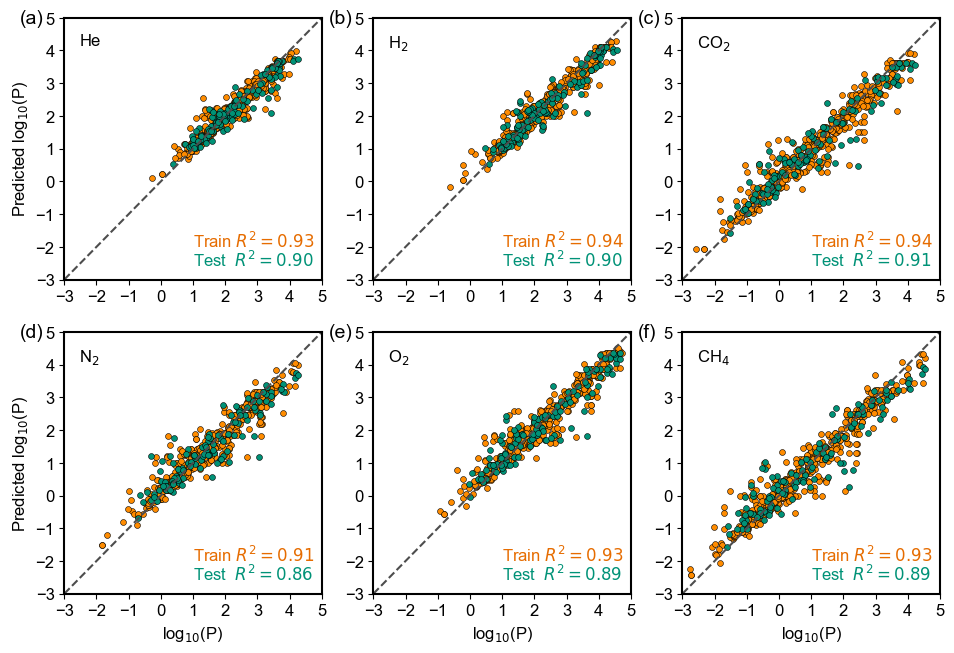

In [36]:
fig, axs = plt.subplot_mosaic([['(a)','(b)','(c)'],['(d)','(e)','(f)']], figsize=(11.3,7.48))
plt.rc('font',family='Arial', weight='medium')

index = [['(a)','(b)','(c)'],['(d)','(e)','(f)']]

for label, ax in axs.items():
    ax.text(-4.38, 5.26, label,
            fontsize='14', verticalalignment='top', fontfamily='Arial',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

axs['(a)'].set_ylabel("Predicted log$_{10}$(P)", fontsize=12)
axs['(d)'].set_ylabel("Predicted log$_{10}$(P)", fontsize=12)

for i in index[1]:
    axs[i].set_xlabel("log$_{10}$(P)", fontsize=12)
    
at = ["He", "H$_{2}$", "CO$_{2}$", "N$_2$", "O$_{2}$", "CH$_{4}$"]

def draw(plt, ax, gas, at):
    gas = int(gas)
    kuang = ['top','bottom','left','right']
    for i in kuang:
        ax.spines[i].set_color('black')
        ax.spines[i].set_linewidth(1.5)
        
    ax.scatter(y_train[:,gas],loaded_model.predict((X_train))[:,gas], label = 'Train', color='#ff8c00', s=18, edgecolors='k', linewidths = 0.4)
    ax.scatter(y_test[:,gas],loaded_model.predict((X_test))[:,gas], label = 'Test', color='#009277', s=18, edgecolors='k', linewidths = 0.4)
    
    
    ax.set_xlim(-3,5)
    ax.set_ylim(-3,5)
    ax.set_xticks(np.arange(-3,5.01))
    ax.set_yticks(np.arange(-3,5.01))
    ax.tick_params(labelsize=12)
    ax.axline((-2,-2), slope=1,ls="--", c=".3")

    ax.text(1, -2, "Train $R^2={:.2f}$".format(round(r2_score(y_train[:,gas], loaded_model.predict((X_train))[:,gas]),2)), c='#e66c00', fontsize=12)
    ax.text(1, -2.6, "Test  $R^2 ={:.2f}$".format(r2_score(y_test[:,gas],loaded_model.predict((X_test))[:,gas])), c='#009277', fontsize=12)
    
    at1 = AnchoredText(
    at, prop=dict(size=12), frameon=0, loc='upper left')
    at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at1)
    
    return plt

list1 = [0,1,2]
list2 = [3,4,5]
for i,j in zip(index[0],list1):
    draw(plt,axs[i], j, at[j])

for i,j in zip(index[1],list2):
    draw(plt,axs[i], j, at[j])
    

plt.savefig('/home/li/polyML/fig/gpr.eps', bbox_inches = 'tight')
plt.savefig('/home/li/polyML/fig/gpr.svg', bbox_inches = 'tight')
plt.savefig('/home/li/polyML/fig/gpr.tif',dpi=300, bbox_inches = 'tight')